In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import KFold
from sklearn.metrics import log_loss, roc_curve, auc
from sklearn.calibration import calibration_curve
from scipy.stats import logistic
import time
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from permutation_weighting.estimator import PW
import matplotlib.gridspec as gridspec
from matplotlib.lines import Line2D
from itertools import product


# Function to create Kang-Schafer data
def create_kang_schafer_data(n, misspecified=False):
    """
    Generate data according to Kang and Schafer (2007) simulation.
    
    Parameters:
    -----------
    n : int
        Sample size
    misspecified : bool
        Whether to use the misspecified covariates
        
    Returns:
    --------
    dict
        Dictionary containing data and true values
    """
    # Generate true covariates
    X_true = np.random.normal(0, 1, (n, 4))
    
    # Propensity score
    linear_pred = X_true[:, 0] - 0.5 * X_true[:, 1] + 0.25 * X_true[:, 2] + 0.1 * X_true[:, 3]
    prop = logistic.cdf(linear_pred)
    
    # Treatment
    A = np.random.binomial(1, prop, n)
    
    # Outcome (note that treatment effect is 1)
    Y = 210 + A + 27.4 * X_true[:, 0] + 13.7 * X_true[:, 1] + 13.7 * X_true[:, 2] + 13.7 * X_true[:, 3] + np.random.normal(0, 1, n)
    
    # Observed covariates (potentially misspecified)
    if misspecified:
        X = np.column_stack([
            np.exp(X_true[:, 0] / 2),
            X_true[:, 1] * (1 + np.exp(X_true[:, 0])) ** (-1) + 10,
            (X_true[:, 0] * X_true[:, 2] / 25 + 0.6) ** 3,
            (X_true[:, 1] + X_true[:, 3] + 20) ** 2
        ])
    else:
        X = X_true.copy()
    
    # True expected outcomes (since X are standard normal, E[X] = 0)
    true_ey0 = 210
    true_ey1 = 211
    
    return {
        'X': X,
        'A': A,
        'Y': Y,
        'true_ey0': true_ey0,
        'true_ey1': true_ey1,
        'true_ate': true_ey1 - true_ey0
    }


# Function to create permutation weighted datasets for training classifiers
def create_pw_dataset(X, A):
    """
    Create permutation weighted dataset for classifier training
    
    Parameters:
    -----------
    X : numpy.ndarray
        Covariate matrix
    A : numpy.ndarray
        Treatment vector
        
    Returns:
    --------
    tuple
        Features (X, A) and labels for classification
    """
    n = len(A)
    # Create permuted dataset
    perm_indices = np.random.permutation(n)
    A_perm = A[perm_indices]
    
    # Stack features for classification
    X_combined = np.vstack([X, X])
    A_combined = np.hstack([A, A_perm])
    
    # Create features with interactions
    X_features = []
    for i in range(X.shape[1]):
        X_features.append(X_combined[:, i])
        X_features.append(X_combined[:, i] * A_combined)
    
    X_features = np.column_stack(X_features)
    
    # Create labels (0 for observed, 1 for permuted)
    labels = np.hstack([np.zeros(n), np.ones(n)])
    
    return X_features, labels


# Configure models with different hyperparameters
def configure_models(classifier_type, param_grid):
    """
    Create a grid of classifiers with different hyperparameters
    
    Parameters:
    -----------
    classifier_type : str
        Type of classifier ('boosting', 'sgd', 'logit', 'mlp')
    param_grid : dict
        Parameter grid for the classifier
        
    Returns:
    --------
    list
        List of (model, params) tuples
    """
    models = []
    
    if classifier_type == 'boosting':
        # Extract parameters
        learning_rates = param_grid.get('learning_rates', [0.1])
        tree_depths = param_grid.get('tree_depths', [3])
        n_estimators_list = param_grid.get('n_estimators', [100])
        
        # Create all combinations
        for depth, lr, n_est in product(tree_depths, learning_rates, n_estimators_list):
            params = {
                'max_depth': depth,
                'learning_rate': lr,
                'n_estimators': n_est
            }
            model = GradientBoostingClassifier(
                max_depth=depth,
                learning_rate=lr,
                n_estimators=n_est,
                random_state=42
            )
            models.append((model, params))
            
    elif classifier_type == 'sgd':
        # Extract parameters
        alphas = param_grid.get('alphas', [0.0001])
        learning_rates = param_grid.get('learning_rates', [0.01])
        penalties = param_grid.get('penalties', ['l2'])
        
        # Create all combinations
        for alpha, lr, penalty in product(alphas, learning_rates, penalties):
            params = {
                'alpha': alpha,
                'eta0': lr,
                'penalty': penalty
            }
            model = SGDClassifier(
                loss='log_loss',
                alpha=alpha,
                learning_rate='constant',
                eta0=lr,
                penalty=penalty,
                max_iter=1000,
                random_state=42
            )
            models.append((model, params))
            
    elif classifier_type == 'logit':
        # Extract parameters
        C_values = param_grid.get('C', [1.0])
        penalties = param_grid.get('penalties', ['l2'])
        max_iters = param_grid.get('max_iter', [1000])
        
        # Create all combinations
        for c, penalty, max_iter in product(C_values, penalties, max_iters):
            if penalty == 'l1':
                solver = 'liblinear'  # liblinear supports L1 penalty
            else:
                solver = 'lbfgs'
                
            params = {
                'C': c,
                'penalty': penalty,
                'max_iter': max_iter
            }
            model = LogisticRegression(
                C=c,
                penalty=penalty,
                solver=solver,
                max_iter=max_iter,
                random_state=42
            )
            models.append((model, params))
            
    elif classifier_type == 'mlp':
        # Extract parameters
        learning_rates = param_grid.get('learning_rates', [0.001])
        hidden_layers = param_grid.get('hidden_layers', [(100,)])
        alphas = param_grid.get('alphas', [0.0001])
        
        # Create all combinations
        for lr, hidden, alpha in product(learning_rates, hidden_layers, alphas):
            params = {
                'learning_rate_init': lr,
                'hidden_layer_sizes': hidden,
                'alpha': alpha
            }
            model = MLPClassifier(
                hidden_layer_sizes=hidden,
                learning_rate_init=lr,
                alpha=alpha,
                max_iter=1000,
                early_stopping=True,
                random_state=42
            )
            models.append((model, params))
            
    else:
        raise ValueError(f"Unknown classifier type: {classifier_type}")
        
    return models


# Function to evaluate model performance using cross-validation
def evaluate_model_cv(X, A, Y, model, n_folds=10):
    """
    Evaluate model performance using cross-validation
    
    Parameters:
    -----------
    X : numpy.ndarray
        Covariate matrix
    A : numpy.ndarray
        Treatment vector
    Y : numpy.ndarray
        Outcome vector
    model : estimator
        Classifier model
    n_folds : int
        Number of cross-validation folds
        
    Returns:
    --------
    dict
        Evaluation metrics
    """
    kf = KFold(n_splits=n_folds, shuffle=True, random_state=42)
    
    # Lists to store results
    in_sample_losses = []
    out_sample_losses = []
    in_sample_causal_errors = []
    in_sample_mse = []
    out_sample_mse = []
    
    tpr_list = []
    fpr_list = []
    
    for train_idx, test_idx in kf.split(X):
        # Split data
        X_train, X_test = X[train_idx], X[test_idx]
        A_train, A_test = A[train_idx], A[test_idx]
        Y_train, Y_test = Y[train_idx], Y[test_idx]
        
        # Create permutation weighted datasets
        X_train_pw, labels_train = create_pw_dataset(X_train, A_train)
        X_test_pw, labels_test = create_pw_dataset(X_test, A_test)
        
        # Train classifier
        model.fit(X_train_pw, labels_train)
        
        # Get predicted probabilities
        train_probs = model.predict_proba(X_train_pw)[:, 1]
        test_probs = model.predict_proba(X_test_pw)[:, 1]
        
        # Calculate log loss
        in_sample_loss = log_loss(labels_train, train_probs)
        out_sample_loss = log_loss(labels_test, test_probs)
        
        in_sample_losses.append(in_sample_loss)
        out_sample_losses.append(out_sample_loss)
        
        # Calculate MSE
        in_sample_mse.append(np.mean((labels_train - train_probs) ** 2))
        out_sample_mse.append(np.mean((labels_test - test_probs) ** 2))
        
        # Calculate weights for original (non-permuted) data
        n_train = len(X_train)
        train_obs_probs = train_probs[:n_train]
        
        # Clip probabilities to avoid extreme weights
        train_obs_probs = np.clip(train_obs_probs, 0.01, 0.99)
        
        weights = train_obs_probs / (1 - train_obs_probs)
        
        # Normalize weights
        weights = weights / np.mean(weights)
        
        # Estimate causal effect
        treated_idx = A_train == 1
        control_idx = A_train == 0
        
        est_ey1 = np.sum(Y_train[treated_idx] * weights[treated_idx]) / np.sum(weights[treated_idx])
        est_ey0 = np.sum(Y_train[control_idx] * weights[control_idx]) / np.sum(weights[control_idx])
        
        est_ate = est_ey1 - est_ey0
        causal_error = np.abs(est_ate - 1.0)  # True ATE is 1.0
        
        in_sample_causal_errors.append(causal_error)
        
        # Compute ROC curve values
        fpr, tpr, _ = roc_curve(labels_test, test_probs)
        tpr_list.append(tpr)
        fpr_list.append(fpr)
    
    # Compute average ROC curves using interpolation
    mean_fpr = np.linspace(0, 1, 100)
    mean_tpr = np.zeros_like(mean_fpr)
    
    for i in range(len(fpr_list)):
        mean_tpr += np.interp(mean_fpr, fpr_list[i], tpr_list[i])
    
    mean_tpr /= len(fpr_list)
    
    return {
        'in_sample_loss': np.mean(in_sample_losses),
        'out_sample_loss': np.mean(out_sample_losses),
        'in_sample_loss_std': np.std(in_sample_losses),
        'out_sample_loss_std': np.std(out_sample_losses),
        'in_sample_mse': np.mean(in_sample_mse),
        'out_sample_mse': np.mean(out_sample_mse),
        'in_sample_mse_std': np.std(in_sample_mse),
        'out_sample_mse_std': np.std(out_sample_mse),
        'in_sample_causal_error': np.mean(in_sample_causal_errors),
        'in_sample_causal_error_std': np.std(in_sample_causal_errors),
        'mean_fpr': mean_fpr,
        'mean_tpr': mean_tpr,
        'auc': auc(mean_fpr, mean_tpr)
    }


# Run cross-validation experiment
def run_experiment(X, A, Y, classifier_type, param_grid):
    """
    Run cross-validation experiment with specified classifier
    
    Parameters:
    -----------
    X : numpy.ndarray
        Covariate matrix
    A : numpy.ndarray
        Treatment vector
    Y : numpy.ndarray
        Outcome vector
    classifier_type : str
        Type of classifier to use
    param_grid : dict
        Parameter grid for the classifier
        
    Returns:
    --------
    pandas.DataFrame
        Results of the experiment
    """
    models = configure_models(classifier_type, param_grid)
    results = []
    
    for model, params in models:
        model_name = type(model).__name__
        print(f"Evaluating {model_name} with {params}")
        
        eval_metrics = evaluate_model_cv(X, A, Y, model)
        
        result = {
            'classifier': classifier_type,
            'model_type': model_name,
            **params,
            **eval_metrics
        }
        
        results.append(result)
    
    return pd.DataFrame(results)


# Plot PW loss vs causal error (similar to Figures 4 and 5)
def plot_pw_loss_vs_causal_error(results, classifier, loss_type='logloss', 
                                 sample_type='out', color_param=None,
                                 column_param=None, save_path=None):
    """
    Plot PW loss vs causal error similar to Figures 4 and 5 in the paper.
    
    Parameters:
    -----------
    results : pandas.DataFrame
        Cross-validation results
    classifier : str
        Classifier type ('logit', 'boosting', 'sgd', 'mlp')
    loss_type : str
        Loss type to use ('logloss' or 'mse')
    sample_type : str
        Sample type ('in' or 'out')
    color_param : str
        Parameter to use for coloring points
    column_param : str
        Parameter to use for creating columns
    save_path : str, optional
        Path to save the plot
    """
    # Filter results for this classifier
    df = results[results['classifier'] == classifier].copy()
    
    if df.empty:
        print(f"No results for classifier {classifier}")
        return
    
    # Set up loss column name based on parameters
    if loss_type == 'logloss':
        loss_col = f"{sample_type}_sample_loss"
        loss_std_col = f"{sample_type}_sample_loss_std"
    else:  # mse
        loss_col = f"{sample_type}_sample_mse"
        loss_std_col = f"{sample_type}_sample_mse_std"
    
    # Set up figure
    if column_param and column_param in df.columns:
        column_values = sorted(df[column_param].unique())
        fig, axes = plt.subplots(1, len(column_values), figsize=(15, 5), sharey=True)
    else:
        column_values = [None]
        fig, axes = plt.subplots(1, 1, figsize=(8, 5))
        axes = [axes]  # Make it a list for consistent indexing
    
    # Plot title
    if sample_type == 'in':
        title_prefix = "In-sample"
    else:
        title_prefix = "Out-of-sample"
    
    fig.suptitle(f"{title_prefix} PW {loss_type} vs Causal Error ({classifier.upper()})", fontsize=16)
    
    # Iterate over columns
    for i, col_val in enumerate(column_values):
        ax = axes[i]
        
        if col_val is not None:
            col_df = df[df[column_param] == col_val]
            ax.set_title(f"{column_param} = {col_val}")
        else:
            col_df = df
        
        # Set up color parameter if specified
        if color_param and color_param in col_df.columns:
            color_values = sorted(col_df[color_param].unique())
            colors = plt.cm.viridis(np.linspace(0, 1, len(color_values)))
            color_map = dict(zip(color_values, colors))
            
            for j, param_val in enumerate(color_values):
                param_df = col_df[col_df[color_param] == param_val]
                ax.scatter(
                    param_df[loss_col], 
                    param_df['in_sample_causal_error'],
                    color=color_map[param_val],
                    label=f"{color_param}={param_val}",
                    s=50
                )
                
                # Add error bars if available
                if loss_std_col in param_df.columns and 'in_sample_causal_error_std' in param_df.columns:
                    for _, row in param_df.iterrows():
                        ax.errorbar(
                            row[loss_col],
                            row['in_sample_causal_error'],
                            xerr=row[loss_std_col],
                            yerr=row['in_sample_causal_error_std'],
                            color=color_map[param_val],
                            alpha=0.5
                        )
        else:
            # No color parameter, just plot all points
            ax.scatter(
                col_df[loss_col], 
                col_df['in_sample_causal_error'],
                s=50
            )
            
            # Add error bars if available
            if loss_std_col in col_df.columns and 'in_sample_causal_error_std' in col_df.columns:
                for _, row in col_df.iterrows():
                    ax.errorbar(
                        row[loss_col],
                        row['in_sample_causal_error'],
                        xerr=row[loss_std_col],
                        yerr=row['in_sample_causal_error_std'],
                        alpha=0.5
                    )
        
        # Add legend and labels
        if color_param and color_param in col_df.columns:
            ax.legend(title=color_param)
        
        ax.set_xlabel(f"PW {loss_type} ({sample_type}-sample)")
        
        # Only add y-label to the first subplot
        if i == 0:
            ax.set_ylabel("Absolute Causal Error (in-sample)")
        
        # Add grid
        ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300)
    
    return fig


# Plot ROC curves
def plot_roc_curves(results_list, classifier_types=None, save_path=None):
    """
    Plot ROC curves for different classifiers
    
    Parameters:
    -----------
    results_list : list of pandas.DataFrame
        List of results dataframes
    classifier_types : list of str, optional
        List of classifier types to include
    save_path : str, optional
        Path to save the plot
    """
    plt.figure(figsize=(10, 8))
    
    # Plot random classifier reference line
    plt.plot([0, 1], [0, 1], 'k--', alpha=0.6, label='Random')
    
    # Initialize colors and markers for different classifiers
    colors = {'boosting': 'g', 'sgd': 'r', 'logit': 'b', 'mlp': 'purple'}
    
    legend_entries = []
    
    for results_df in results_list:
        # If classifier_types is provided, filter results
        if classifier_types:
            results_df = results_df[results_df['classifier'].isin(classifier_types)]
        
        # Group results by classifier type
        for classifier, group in results_df.groupby('classifier'):
            color = colors.get(classifier, 'gray')
            
            # Find best and worst models by AUC
            best_model = group.loc[group['auc'].idxmax()]
            worst_model = group.loc[group['auc'].idxmin()]
            
            # Plot best model
            plt.plot(best_model['mean_fpr'], best_model['mean_tpr'], 
                    color=color, linestyle='-', linewidth=2,
                    label=f"{classifier.upper()} (best, AUC={best_model['auc']:.3f})")
            
            # Only plot worst model if different from best
            if len(group) > 1 and best_model['auc'] != worst_model['auc']:
                plt.plot(worst_model['mean_fpr'], worst_model['mean_tpr'], 
                        color=color, linestyle='--', linewidth=1.5,
                        label=f"{classifier.upper()} (worst, AUC={worst_model['auc']:.3f})")
    
    plt.xlabel('False Positive Rate', fontsize=14)
    plt.ylabel('True Positive Rate', fontsize=14)
    plt.title('ROC Curves for Different Models', fontsize=16)
    plt.legend(loc='lower right', fontsize=12)
    plt.grid(True, alpha=0.3)
    
    # Format as percentages
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.xticks(np.arange(0, 1.1, 0.25), [f'{int(x*100)}%' for x in np.arange(0, 1.1, 0.25)])
    plt.yticks(np.arange(0, 1.1, 0.25), [f'{int(y*100)}%' for y in np.arange(0, 1.1, 0.25)])
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300)
    
    plt.show()


# Compare best models from each classifier type
def compare_best_models(results_list, classifier_types=None, metric='in_sample_causal_error', save_path=None):
    """
    Compare best models from each classifier type
    
    Parameters:
    -----------
    results_list : list of pandas.DataFrame
        List of results dataframes
    classifier_types : list of str, optional
        List of classifier types to include
    metric : str
        Metric to use for comparison
    save_path : str, optional
        Path to save the plot
    
    Returns:
    --------
    pandas.DataFrame
        Comparison of best models
    """
    best_models = []
    
    for results_df in results_list:
        # If classifier_types is provided, filter results
        if classifier_types:
            results_df = results_df[results_df['classifier'].isin(classifier_types)]
        
        # Group results by classifier type
        for classifier, group in results_df.groupby('classifier'):
            # Find best model by metric
            if metric in group.columns:
                if metric == 'auc':  # Higher is better
                    best_idx = group[metric].idxmax()
                else:  # Lower is better for errors and losses
                    best_idx = group[metric].idxmin()
                
                best_model = group.loc[best_idx]
                
                # Format params
                param_str = ", ".join([f"{k}={v}" for k, v in best_model.items() 
                                     if k not in ['classifier', 'model_type', 'mean_fpr', 'mean_tpr']])
                
                best_models.append({
                    'classifier': classifier,
                    'model_type': best_model['model_type'],
                    'params': param_str,
                    'in_sample_loss': best_model.get('in_sample_loss', np.nan),
                    'out_sample_loss': best_model.get('out_sample_loss', np.nan),
                    'in_sample_causal_error': best_model.get('in_sample_causal_error', np.nan),
                    'auc': best_model.get('auc', np.nan)
                })
    
    comparison_df = pd.DataFrame(best_models)
    
    # Plot comparison
    plt.figure(figsize=(12, 7))
    
    # Plot causal error
    plt.subplot(1, 2, 1)
    sns.barplot(x='classifier', y='in_sample_causal_error', data=comparison_df)
    plt.title('Absolute Causal Error by Classifier Type')
    plt.ylabel('Absolute Causal Error')
    plt.xlabel('')
    plt.xticks(rotation=45)
    
    # Plot out-of-sample loss
    plt.subplot(1, 2, 2)
    sns.barplot(x='classifier', y='out_sample_loss', data=comparison_df)
    plt.title('Out-of-Sample PW Loss by Classifier Type')
    plt.ylabel('Out-of-Sample PW Loss')
    plt.xlabel('')
    plt.xticks(rotation=45)
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300)
    
    plt.show()
    
    return comparison_df


# Main function to run all experiments
def run_all_experiments(n=1000, misspecified=False, param_grids=None, output_dir=None):
    """
    Run all experiments and automatically generate plots
    
    Parameters:
    -----------
    n : int
        Sample size
    misspecified : bool
        Whether to use misspecified covariates
    param_grids : dict
        Parameter grids for each classifier type
    output_dir : str, optional
        Directory to save plots
    
    Returns:
    --------
    dict
        Results of all experiments
    """
    import os
    
    # Create output directory if specified and doesn't exist
    if output_dir:
        os.makedirs(output_dir, exist_ok=True)
    
    # Default parameter grids if not provided
    if param_grids is None:
        param_grids = {
            'boosting': {
                'learning_rates': [0.01, 0.05, 0.1],
                'tree_depths': [2, 4, 6, 8],
                'n_estimators': [100, 250, 500]
            },
            'sgd': {
                'alphas': [0.0001, 0.001, 0.01],
                'learning_rates': [0.001, 0.01, 0.1],
                'penalties': ['l2', 'l1']
            },
            'logit': {
                'C': [0.1, 1.0, 10.0],
                'penalties': ['l2'],
                'max_iter': [1000]
            },
            'mlp': {
                'learning_rates': [0.001, 0.01, 0.1],
                'hidden_layers': [(32,), (64,), (32, 16), (64, 32)],
                'alphas': [0.0001, 0.001, 0.01]
            }
        }
    
    # Create Kang-Schafer data
    print(f"Generating Kang-Schafer data (n={n}, misspecified={misspecified})...")
    data = create_kang_schafer_data(n, misspecified)
    X, A, Y = data['X'], data['A'], data['Y']
    
    # Run experiments for each classifier type
    results = {}
    all_dfs = []
    
    for clf_type, params in param_grids.items():
        print(f"\nRunning experiment for {clf_type.upper()}...")
        results_df = run_experiment(X, A, Y, clf_type, params)
        results[clf_type] = results_df
        all_dfs.append(results_df)
        
        # Define color and column parameters based on classifier type
        if clf_type == 'boosting':
            color_param = 'max_depth'
            column_param = 'learning_rate'
        elif clf_type == 'sgd':
            color_param = 'eta0'
            column_param = 'alpha'
        elif clf_type == 'logit':
            color_param = 'penalty'
            column_param = 'C'
        elif clf_type == 'mlp':
            color_param = 'hidden_layer_sizes'
            column_param = 'learning_rate_init'
        else:
            color_param = None
            column_param = None
        
        # Generate plots
        print(f"Generating plots for {clf_type.upper()}...")
        
        # In-sample loss vs causal error
        save_path = None
        if output_dir:
            save_path = os.path.join(output_dir, f"{clf_type}_in_sample_logloss_vs_causal_error.png")
        
        plot_pw_loss_vs_causal_error(
            results_df,
            classifier=clf_type,
            loss_type='logloss',
            sample_type='in',
            color_param=color_param,
            column_param=column_param,
            save_path=save_path
        )
        plt.close()
        
        # Out-sample loss vs causal error
        if output_dir:
            save_path = os.path.join(output_dir, f"{clf_type}_out_sample_logloss_vs_causal_error.png")
        
        plot_pw_loss_vs_causal_error(
            results_df,
            classifier=clf_type,
            loss_type='logloss',
            sample_type='out',
            color_param=color_param,
            column_param=column_param,
            save_path=save_path
        )
        plt.close()
        
        # In-sample MSE vs causal error
        if output_dir:
            save_path = os.path.join(output_dir, f"{clf_type}_in_sample_mse_vs_causal_error.png")
        
        plot_pw_loss_vs_causal_error(
            results_df,
            classifier=clf_type,
            loss_type='mse',
            sample_type='in',
            color_param=color_param,
            column_param=column_param,
            save_path=save_path
        )
        plt.close()
    
    # Generate comparison plots for all classifier types
    print("\nGenerating comparison plots for all classifier types...")
    
    # ROC curves
    if output_dir:
        save_path = os.path.join(output_dir, "all_roc_curves.png")
    else:
        save_path = None
    
    plot_roc_curves(all_dfs, save_path=save_path)
    plt.close()
    
    # Model comparison
    if output_dir:
        save_path = os.path.join(output_dir, "best_models_comparison.png")
    else:
        save_path = None
    
    compare_best_models(all_dfs, save_path=save_path)
    plt.close()
    
    return results

Generating Kang-Schafer data (n=2000, misspecified=False)...

Running experiment for BOOSTING...
Evaluating GradientBoostingClassifier with {'max_depth': 2, 'learning_rate': 0.001, 'n_estimators': 100}
Evaluating GradientBoostingClassifier with {'max_depth': 2, 'learning_rate': 0.001, 'n_estimators': 250}
Evaluating GradientBoostingClassifier with {'max_depth': 2, 'learning_rate': 0.001, 'n_estimators': 500}
Evaluating GradientBoostingClassifier with {'max_depth': 2, 'learning_rate': 0.001, 'n_estimators': 1000}
Evaluating GradientBoostingClassifier with {'max_depth': 2, 'learning_rate': 0.001, 'n_estimators': 2000}
Evaluating GradientBoostingClassifier with {'max_depth': 2, 'learning_rate': 0.01, 'n_estimators': 100}
Evaluating GradientBoostingClassifier with {'max_depth': 2, 'learning_rate': 0.01, 'n_estimators': 250}
Evaluating GradientBoostingClassifier with {'max_depth': 2, 'learning_rate': 0.01, 'n_estimators': 500}
Evaluating GradientBoostingClassifier with {'max_depth': 2, 'lea

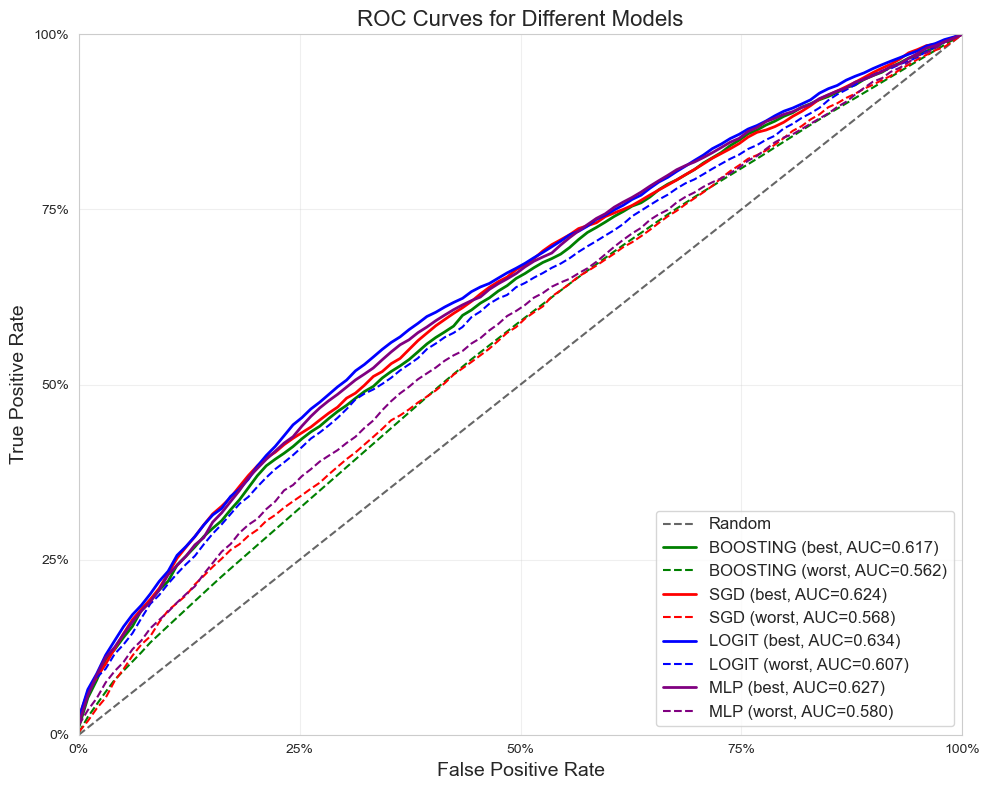

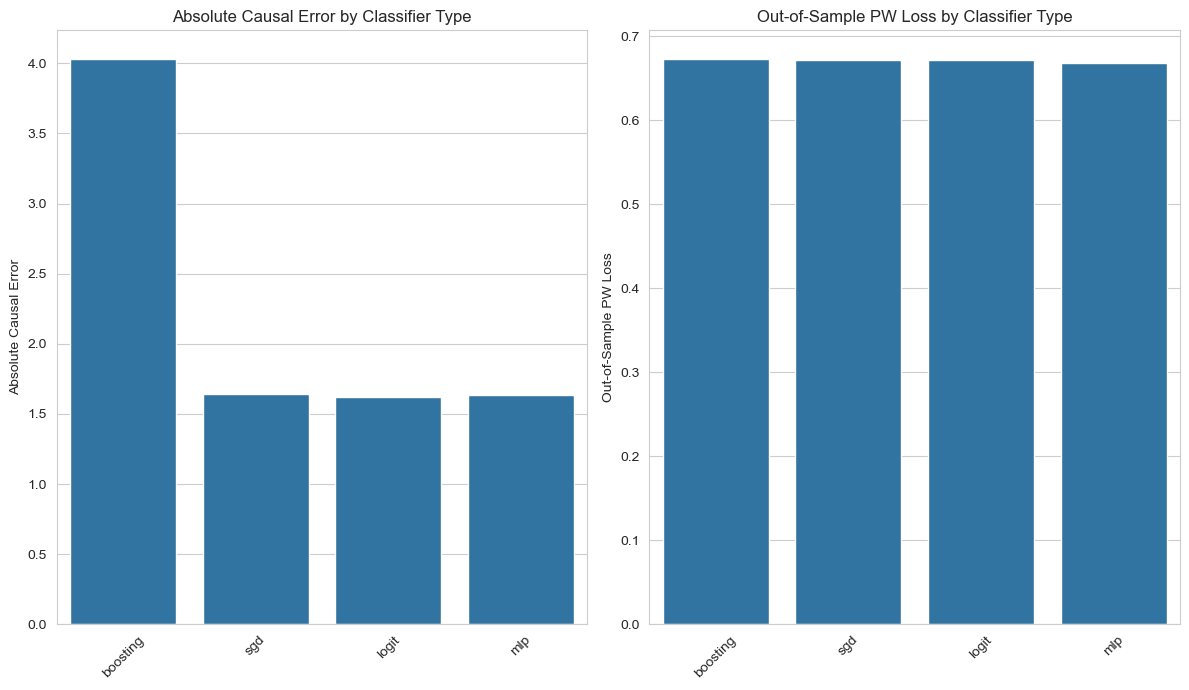

Generating Kang-Schafer data (n=2000, misspecified=True)...

Running experiment for BOOSTING...
Evaluating GradientBoostingClassifier with {'max_depth': 2, 'learning_rate': 0.001, 'n_estimators': 100}
Evaluating GradientBoostingClassifier with {'max_depth': 2, 'learning_rate': 0.001, 'n_estimators': 250}
Evaluating GradientBoostingClassifier with {'max_depth': 2, 'learning_rate': 0.001, 'n_estimators': 500}
Evaluating GradientBoostingClassifier with {'max_depth': 2, 'learning_rate': 0.001, 'n_estimators': 1000}
Evaluating GradientBoostingClassifier with {'max_depth': 2, 'learning_rate': 0.001, 'n_estimators': 2000}
Evaluating GradientBoostingClassifier with {'max_depth': 2, 'learning_rate': 0.01, 'n_estimators': 100}
Evaluating GradientBoostingClassifier with {'max_depth': 2, 'learning_rate': 0.01, 'n_estimators': 250}
Evaluating GradientBoostingClassifier with {'max_depth': 2, 'learning_rate': 0.01, 'n_estimators': 500}
Evaluating GradientBoostingClassifier with {'max_depth': 2, 'lear

/Users/johannesmuller/miniconda3/envs/pw_env/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/johannesmuller/miniconda3/envs/pw_env/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/

Evaluating LogisticRegression with {'C': 0.1, 'penalty': 'l2', 'max_iter': 200}


/Users/johannesmuller/miniconda3/envs/pw_env/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/johannesmuller/miniconda3/envs/pw_env/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/

Evaluating LogisticRegression with {'C': 0.1, 'penalty': 'l2', 'max_iter': 800}
Evaluating LogisticRegression with {'C': 0.1, 'penalty': 'l2', 'max_iter': 1000}
Evaluating LogisticRegression with {'C': 0.1, 'penalty': 'l1', 'max_iter': 100}


/Users/johannesmuller/miniconda3/envs/pw_env/lib/python3.11/site-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/johannesmuller/miniconda3/envs/pw_env/lib/python3.11/site-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Evaluating LogisticRegression with {'C': 0.1, 'penalty': 'l1', 'max_iter': 200}
Evaluating LogisticRegression with {'C': 0.1, 'penalty': 'l1', 'max_iter': 800}
Evaluating LogisticRegression with {'C': 0.1, 'penalty': 'l1', 'max_iter': 1000}
Evaluating LogisticRegression with {'C': 1.0, 'penalty': 'l2', 'max_iter': 100}
Evaluating LogisticRegression with {'C': 1.0, 'penalty': 'l2', 'max_iter': 200}


/Users/johannesmuller/miniconda3/envs/pw_env/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/johannesmuller/miniconda3/envs/pw_env/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/

Evaluating LogisticRegression with {'C': 1.0, 'penalty': 'l2', 'max_iter': 800}
Evaluating LogisticRegression with {'C': 1.0, 'penalty': 'l2', 'max_iter': 1000}
Evaluating LogisticRegression with {'C': 1.0, 'penalty': 'l1', 'max_iter': 100}


/Users/johannesmuller/miniconda3/envs/pw_env/lib/python3.11/site-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/johannesmuller/miniconda3/envs/pw_env/lib/python3.11/site-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/johannesmuller/miniconda3/envs/pw_env/lib/python3.11/site-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Evaluating LogisticRegression with {'C': 1.0, 'penalty': 'l1', 'max_iter': 200}
Evaluating LogisticRegression with {'C': 1.0, 'penalty': 'l1', 'max_iter': 800}
Evaluating LogisticRegression with {'C': 1.0, 'penalty': 'l1', 'max_iter': 1000}
Evaluating LogisticRegression with {'C': 10.0, 'penalty': 'l2', 'max_iter': 100}


/Users/johannesmuller/miniconda3/envs/pw_env/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/johannesmuller/miniconda3/envs/pw_env/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/

Evaluating LogisticRegression with {'C': 10.0, 'penalty': 'l2', 'max_iter': 200}


/Users/johannesmuller/miniconda3/envs/pw_env/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/johannesmuller/miniconda3/envs/pw_env/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/

Evaluating LogisticRegression with {'C': 10.0, 'penalty': 'l2', 'max_iter': 800}
Evaluating LogisticRegression with {'C': 10.0, 'penalty': 'l2', 'max_iter': 1000}
Evaluating LogisticRegression with {'C': 10.0, 'penalty': 'l1', 'max_iter': 100}


/Users/johannesmuller/miniconda3/envs/pw_env/lib/python3.11/site-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/johannesmuller/miniconda3/envs/pw_env/lib/python3.11/site-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/johannesmuller/miniconda3/envs/pw_env/lib/python3.11/site-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/johannesmuller/miniconda3/envs/pw_env/lib/python3.11/site-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/johannesmuller/miniconda3/envs/pw_env/lib/python3.11/site-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  

Evaluating LogisticRegression with {'C': 10.0, 'penalty': 'l1', 'max_iter': 200}
Evaluating LogisticRegression with {'C': 10.0, 'penalty': 'l1', 'max_iter': 800}
Evaluating LogisticRegression with {'C': 10.0, 'penalty': 'l1', 'max_iter': 1000}
Generating plots for LOGIT...

Running experiment for MLP...
Evaluating MLPClassifier with {'learning_rate_init': 0.001, 'hidden_layer_sizes': (16,), 'alpha': 0.0001}
Evaluating MLPClassifier with {'learning_rate_init': 0.001, 'hidden_layer_sizes': (16,), 'alpha': 0.001}
Evaluating MLPClassifier with {'learning_rate_init': 0.001, 'hidden_layer_sizes': (16,), 'alpha': 0.01}
Evaluating MLPClassifier with {'learning_rate_init': 0.001, 'hidden_layer_sizes': (32,), 'alpha': 0.0001}
Evaluating MLPClassifier with {'learning_rate_init': 0.001, 'hidden_layer_sizes': (32,), 'alpha': 0.001}
Evaluating MLPClassifier with {'learning_rate_init': 0.001, 'hidden_layer_sizes': (32,), 'alpha': 0.01}
Evaluating MLPClassifier with {'learning_rate_init': 0.001, 'hidd

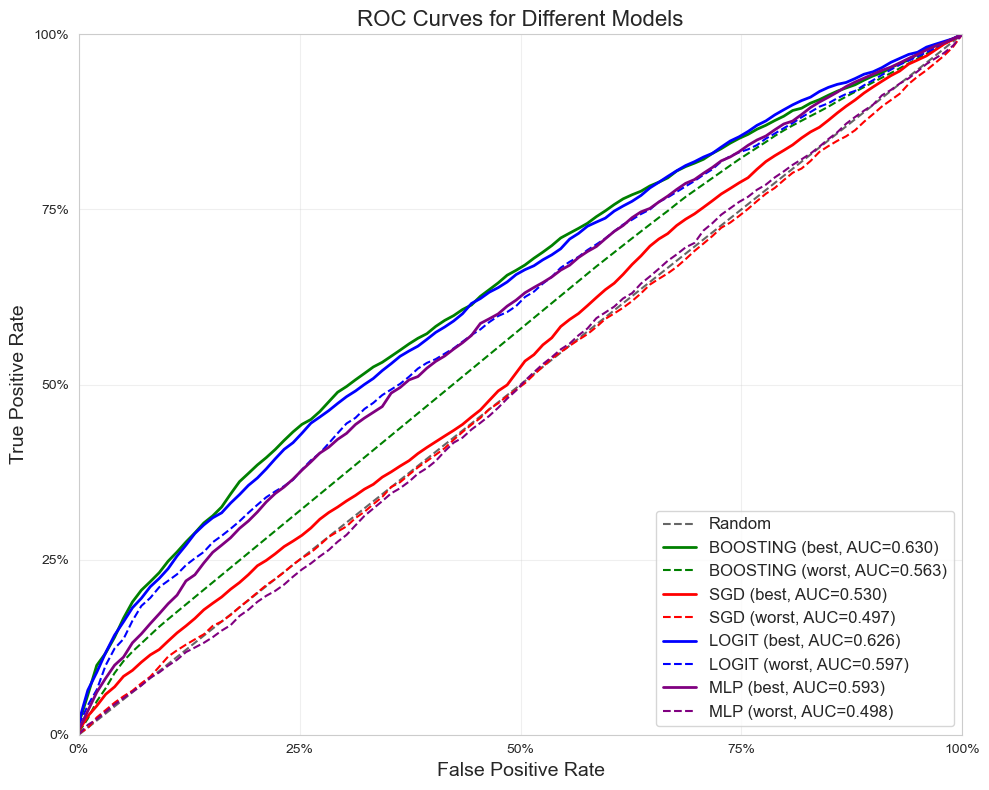

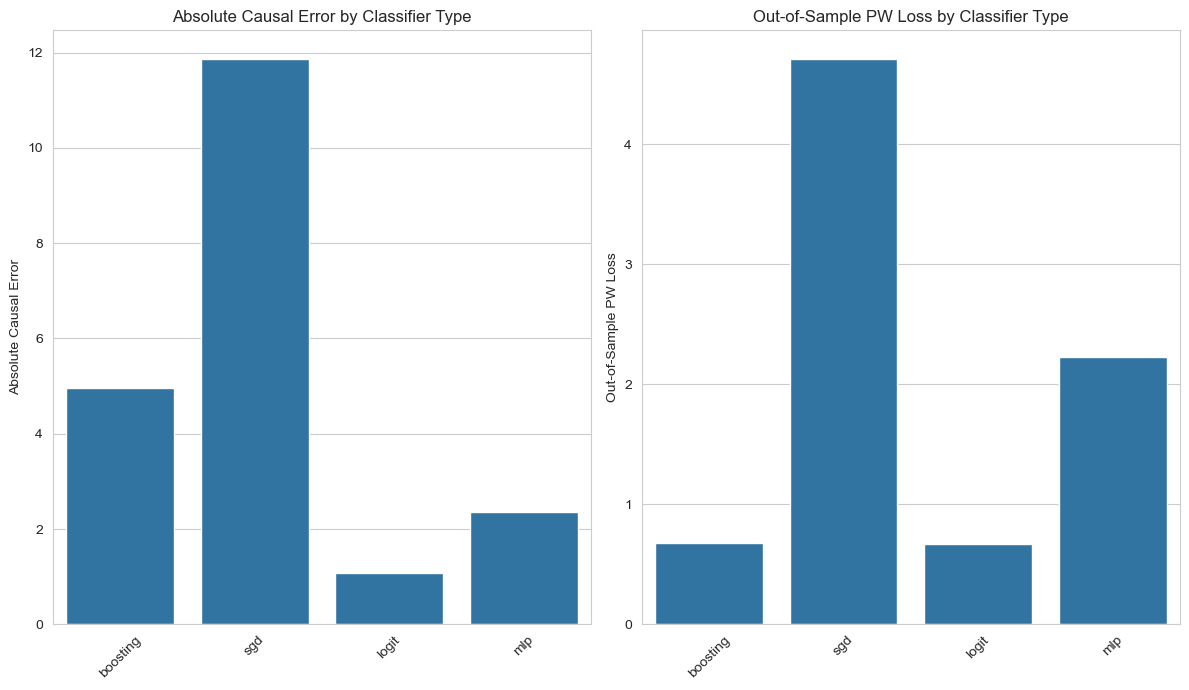

In [3]:
param_grids = {
            'boosting': {
                'learning_rates': [0.001, 0.01, 0.1],
                'tree_depths': [2, 4, 6, 8],
                'n_estimators': [100, 250, 500, 1000, 2000]
            },
            'sgd': {
                'alphas': [0.0001, 0.001, 0.01],
                'learning_rates': [0.001, 0.01, 0.1],
                'penalties': ['l2', 'l1', ]
            },
            'logit': {
                'C': [0.1, 1.0, 10.0],
                'penalties': ['l2','l1'],
                'max_iter': [100, 200, 800, 1000]
            },
            'mlp': {
                'learning_rates': [0.001, 0.01, 0.1],
                'hidden_layers': [(16,),(32,), (64,),(128,), (32, 16), (64, 32)],
                'alphas': [0.0001, 0.001, 0.01]
            }
        }


results = run_all_experiments(
    n=2000, 
    misspecified=False,
    param_grids=param_grids,
    output_dir='./hyper_well_2000'
)

results = run_all_experiments(
    n=2000, 
    misspecified=True,
    param_grids=param_grids,
    output_dir='./hyper_miss_2000'
)